<!-- # Assignment 1 Scientific Computing  -->

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import numba 
from matplotlib.animation import FuncAnimation
import os
import pickle as pkl
from IPython.display import HTML


In [2]:
import src.solutions as solutions
import src.visualizations as visualizations


In [3]:
colors = ["orange", "blue", "green", "purple", "brown"]

## Waves

The discretized wave equation becomes (with functions from solutions): 

### Initial values for discretized wave function
Euler's method: f_x+1 = f_x + h * f'_x

(c*delta t)/delta x < 1 for stable computation 
looking at this method, you can derive that in the first two time-points, the function follows the exact same curve as the derivative (f'_x) is 0

### Plotted snapshots of the wave at different times

In [4]:
L = 1
N = 100
c = 1
deltat= 0.001
iterations = 30000
overall_solutions=[]

# save a solution for every 3000 timesteps to plot
for i in range(3):
    overall_solution, xs = solutions.one_b_wrapper(i+1, L, N, c, deltat, iterations)
    overall_solutions.append(overall_solution)

In [ ]:
visualizations.visualization_1b(overall_solutions, xs, deltat, iterations)

### Wave Animation 

In [ ]:
%matplotlib inline
wave_anim = visualizations.animate_1c(L, N, c, deltat)
saved_anim = "plots/network_animation10.gif"
HTML(f'<img src="{saved_anim}" style="width: 600px;">')

The equations for the boundaries:

c^(k+1)_(0, j) = 1 -> top row <br>
c^(k+1)_(N-1, j) = 0 -> bottom row <br>
c^(k+1)_(i, 0) = c^(k+1)_(i, N - 2) -> first column <br>
c^(k+1)_(i, -1) = c^(k+1)_(i, 1) -> last column <br>

## Diffusion

In [7]:
# values used for initial diffusion setup 
# main parameter values (for discretization)
N = 100
L = 1.0
D = 1

# setp sizes
dx = L / N
dt = 0.25 * dx**2

# initial setup
gamma = (D * dt) / (dx**2) #what is this gamma
num_steps = int(1.0/ dt)
y_values = np.linspace(0, 1, N)
c = solutions.initialize_grid(N)

par_values = (c, num_steps, N, gamma, dt)

#### Comparison analytical with numerical solution

In [ ]:

# parse data and check directory layout and file existence or create new data
create_new_data = False
data_file = "2D_diffusion.pkl"
all_c, times = solutions.check_and_parse_data(data_file, create_new_data, par_values)

# visualize the data together with analytical solution. 
# visualizations.plot_analytical_solution(y_values, all_c, times, D)
visualizations.plot_analytical_solution_with_error(y_values, all_c, times, D)


#### Snapshot of 5 Diffusion configurations

In [ ]:
# t values 0, 0.001, 0.01, 0.1, 1.0
visualizations.plot_five_states(all_c, times)


#### Animation

In [ ]:


# data parsing/generation 
data_file = "2D_diffusion_comparison.pkl"
create_new_data = False
all_c, times = solutions.check_and_parse_data(data_file, create_new_data, par_values)

# visualizations.plot_simulation_without_animation(all_c, N)

# animation 
%matplotlib inline
anim = visualizations.animate_2f(solutions.update, c, num_steps, N, gamma, dt)
HTML(anim.to_jshtml())

In [10]:
# parameters for H-J
N = 50
max_iters = 10000
p_values = np.arange(0, 11)
omegas = [1.7, 1.8, 1.9]
tol = 1e-6
omega = 1.9
omega_range = np.arange(1.7, 2.0, 0.05)
N_values = [10, 20, 50, 100]
optimal_omegas = {}
iters_N = {}

H

 Implement the Jacobi iteration, the Gauss-Seidel method and SOR.
 Try N =50. Test the methods by comparing the result to the analytical result in
 eq. (5), i.e. the linear dependence of the concentration on y.

In [ ]:
_, c_jacobi_2d = solutions.sequential_jacobi(N, tol, max_iters)
_, c_gs_2d     = solutions.sequential_gauss_seidel(N, tol, max_iters)
_, c_sor_2d    = solutions.sequential_SOR(N, tol, max_iters, omega)

visualizations.visualization_1h(c_jacobi_2d, c_gs_2d, c_sor_2d, N)

I

Show how the convergence measure δ in eq. (14) depends on the number
 of iterations k for each of the methods. A log-lin plot may be suitable. For SOR,
 choose a few representative values for ω.

In [ ]:
results_jacobi = [solutions.sequential_jacobi(N=N, tol=10.0**-p, max_iters=max_iters) for p in p_values]
iterations_jacobi, _ = zip(*results_jacobi)

results_gauss_seidel = [solutions.sequential_gauss_seidel(N=N, tol=10.0**-p, max_iters=max_iters) for p in p_values]
iterations_gauss_seidel, _ = zip(*results_gauss_seidel)

results_sor = {omega: [solutions.sequential_SOR(N=N, tol=10.0**-p, max_iters=max_iters, omega=omega) for p in p_values] for omega in omegas}
iterations_sor = {omega: [result[0] for result in results_sor[omega]] for omega in omegas}

visualizations.visualization_1i(p_values, iterations_jacobi, iterations_gauss_seidel, iterations_sor, colors=colors)

J 

In the SOR method, find the optimal ω. How does it depend on N?.

In [ ]:
for N in N_values:
    best_omega = None
    min_iters = float('inf')

    iters_omega = []

    for omega in omega_range:
        iters, _ = solutions.sequential_SOR(N=N, tol=1e-6, max_iters=max_iters, omega=omega)

        iters_omega.append(iters)

        if iters < min_iters:
            min_iters = iters
            best_omega = omega

    optimal_omegas.append(best_omega)
    iters_N[N] = iters_omega

visualizations.visualization_1j_omega_iters(iters_N, omega_range, colors=colors)
visualizations.visualization_1j_N_omegas(N_values, optimal_omegas, colors=colors)

### K: Objects

#### Define Parameters and Create Object Grids

In [4]:
# parameters for experimentation 
max_iters = 10000 #after this we stop trying to converge

omega_range = np.arange(1.7, 2.0, 0.05)
omega_range = np.round(omega_range, 2)
omega_range_c = np.delete(omega_range, -1) #omegas for experimentation 

N_values = [10, 20, 50, 100] #experimental vlaues for grid size
omegatje= 1.9 #optimal omega for grid size 50X50
tol = 1e-6 #default tol
PROCESSES = 10  #number of processes for parallelization 
N=50 #default grid size
num_grids = 10 # number of object grids with the same configuration are created (as they're placed randomly multiple runs are needed)


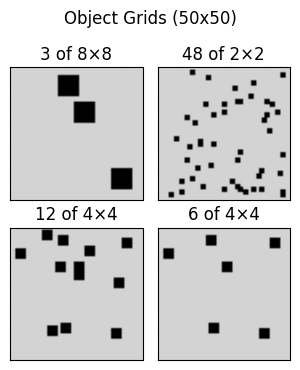

In [5]:

# different object configurations (note that the covered surface for the first 3 configs is the same)
object_configs = [
    (3, 8),   # 3 objects of size 8x8
    (48, 2),  # 48 objects of size 2x2
    (12, 4),  # 12 objects of size 4x4
    (6, 4)   # 6 objects of size 4x4
]


# naming of the object configurations run with SOR
sizes = [
        "3 of 8×8",
        "48 of 2×2",
        "12 of 4×4",
        "6 of 4×4", 
        "0 of 0x0"
    ]

# Saving all grids in a dictionary. 
all_grids = dict()
for ntje in N_values:
    # skip if N is smaller than 20, than the objects are too big in contrast to the gridsizes
    if ntje <20:
        continue

    # objects (following configuration) are randomly placed on the grid
    object_grids = solutions.create_object_layouts(ntje, object_configs, num_grids)
    all_grids[ntje] = object_grids
    # take an examplatory grid to visualize

# Visualization of 50x50 grid with all object configurations 
visualizations.visualize_object_grid(all_grids[50], sizes)


#### Apply SOR on different grids for all object configuraitons (parallelized over different runs)

In [6]:
# get the mean, variance of every grid size for every object configuration (takes 1 min)
# null metric is for grid without any objects 
all_results, solutions_map, null_metric = solutions.generate_grid_results(N_values, N, all_grids, num_grids, max_iters, omegatje, tol, object_configs, "N", PROCESSES)

starting parallel implementation of SOR for grid size 20x20, omega: 1.9
starting parallel implementation of SOR for grid size 50x50, omega: 1.9
starting parallel implementation of SOR for grid size 100x100, omega: 1.9


#### Apply SOR on different omega values for all object configuraitons (parallelized over different runs)


In [27]:
# get the mean, variance of every omega for every object configuration (takes 1 min)
# null metric is for grid without any objects
all_results_omega, solutions_map_omega, null_metric_omega = solutions.generate_grid_results(omega_range_c, N, all_grids, num_grids, max_iters, omegatje, tol, object_configs, "O", PROCESSES)

starting parallel implementation of SOR for grid size 50x50, omega: 1.7
starting parallel implementation of SOR for grid size 50x50, omega: 1.75
starting parallel implementation of SOR for grid size 50x50, omega: 1.8
starting parallel implementation of SOR for grid size 50x50, omega: 1.85
starting parallel implementation of SOR for grid size 50x50, omega: 1.9
starting parallel implementation of SOR for grid size 50x50, omega: 1.95


#### Visualize results for different grid sizes and omega values for all object configurations

In [40]:
def plot_five_states(all_c, iterate_through,config, which_one="N"):
    """
    function plotting the 2D diffustion grid,
    5 states for t = 0, 0.001, 0.01, 0.1, 1.0
    """

    assert len(all_c.keys()) == len(iterate_through), "Data provided and variables used for experimentation don't allign"

    # plot setup
    if which_one == "O":
        sizeje = (6.6, 5.3)
        fx = 3
        fy = 2
        titletje = r"$\omega$"
        h=0.78
    elif which_one == "N":
        sizeje= (6.6, 3.3)
        fx = 3
        fy =1
        titletje = "Grid Size"
        h = 0.65
    else: 
        raise ValueError(f"{which_one} is not a valid experimentation, choose N or O")
    
    fig, axs = plt.subplots(fy, fx, figsize=sizeje)
    fig.suptitle(f"Grid diffusion (Object configuration {config})")
    axs = axs.flatten()

    for ktje, i in enumerate(iterate_through):
        # print(all_c[i])
        im = axs[ktje].imshow(
            all_c[i][config], cmap="viridis", interpolation="nearest", origin="lower"
        )
        if fx <2:
            axs[ktje].set_xlabel("x")
        elif ktje > 2:
            axs[ktje].set_xlabel("x")
        axs[ktje].set_title(titletje + f"{i}")
  
    axs[0].set_ylabel("y")
    if fy > 1:
        axs[3].set_ylabel("y")

    cbar_ax = fig.add_axes([0.92, 0.09, 0.02, h])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label="Concentration")

    plt.tight_layout(rect=[0, 0, 0.93, 1])
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.savefig("plots/diffusion_snapshots.png", dpi=300)
    plt.show()

C:\Users\chris\AppData\Local\Temp\ipykernel_21656\3985657834.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 1])


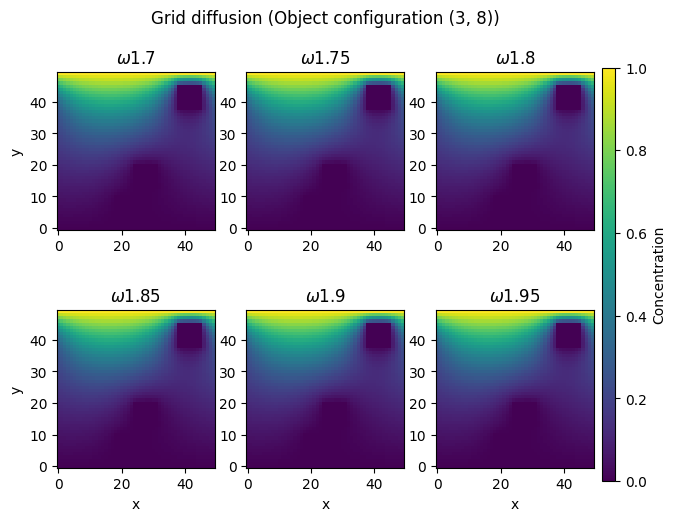

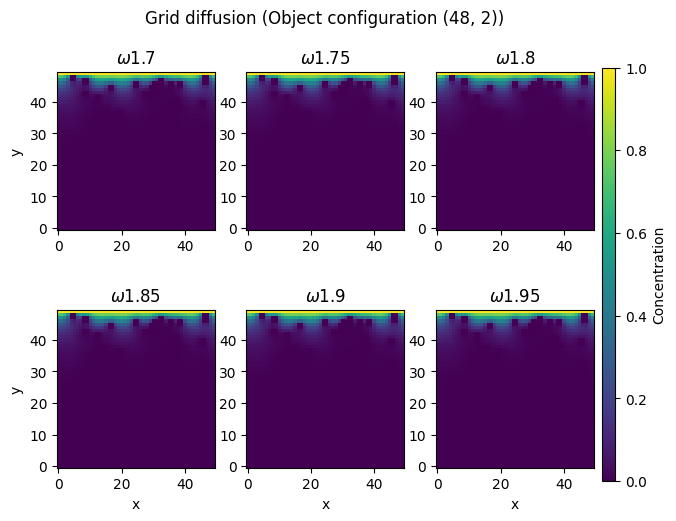

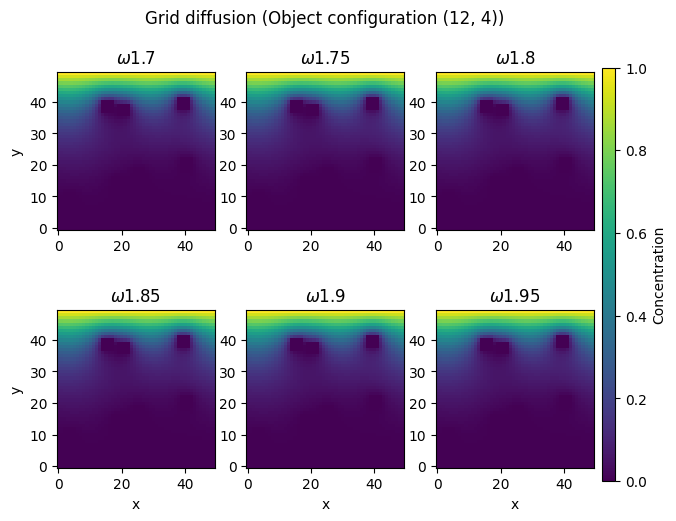

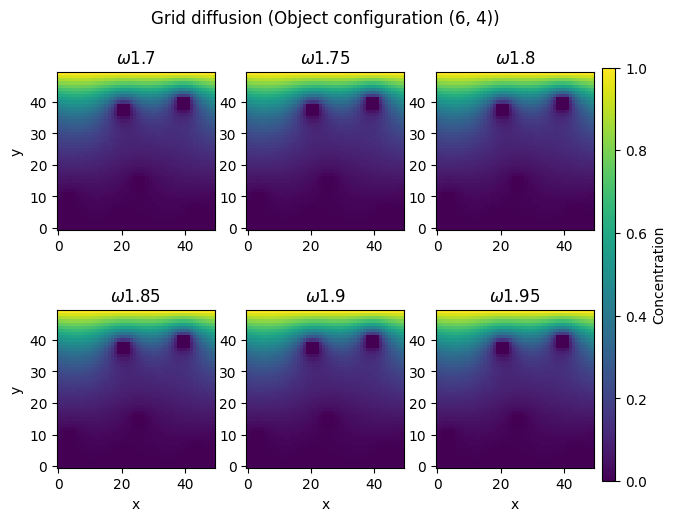

In [41]:
for config_label in object_configs:
    plot_five_states(solutions_map_omega, omega_range_c, config_label, "O")

C:\Users\chris\AppData\Local\Temp\ipykernel_21656\1357816217.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 1])


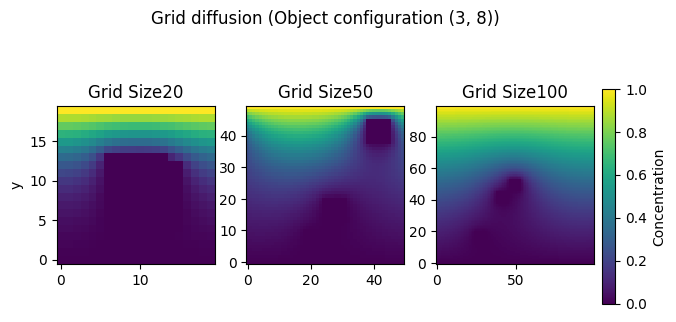

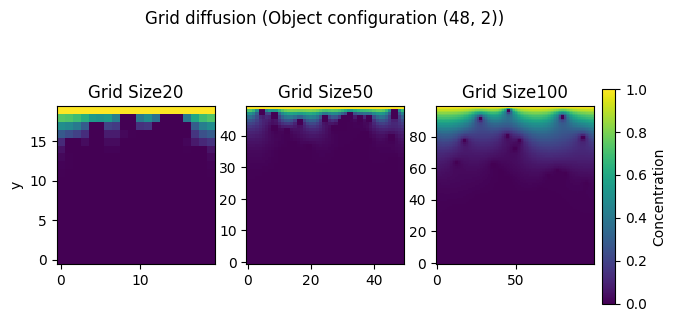

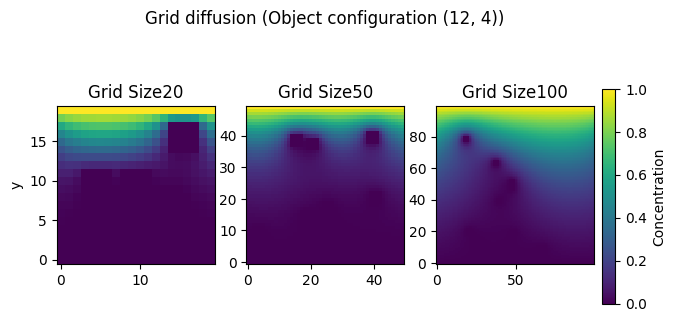

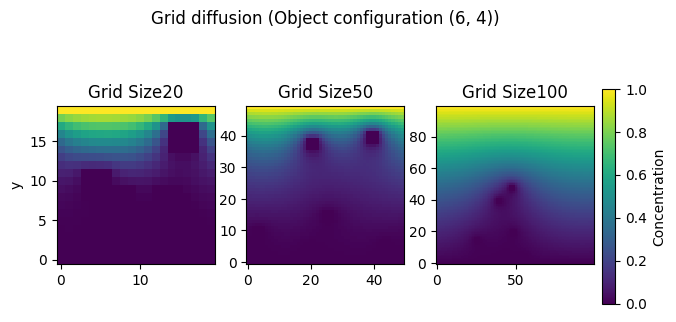

In [26]:

keyvals = [20, 50, 100]
# Iterate over each object configuration and plot a separate line
for i, config_label in enumerate(object_configs):
    plot_five_states(solutions_map, keyvals, config_label)



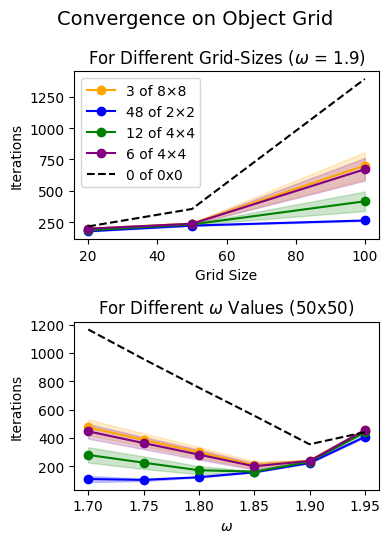

In [19]:
visualizations.vis_object_per_gridsize(all_results, all_results_omega, null_metric, null_metric_omega, object_configs, sizes, colors)

#### Statistical Testing for every object configuration

In [14]:
solutions.statistical_test_for_objects(object_configs, all_results_omega)
solutions.statistical_test_for_objects(object_configs, all_results, "N")

Statistical results saved to data/statistical_ttest_O.txt
Statistical results saved to data/statistical_ttest_N.txt
